Geo Aggregation Code

including
- reading in geodatasets
- funktionierende Delaunay Triangulation
- Auslesen von Geometries in nutzbare Polygons
- Auslesen von Node Koordinaten in nutzbare Points
- Delaunay Triangulation der Nodes
- Abbruchkriterien bei extrem langen Connections - 400km


In [1]:
#Aggregation algorithm for renewable potentials and energy systems infrastructure

#This code aims to provide an universally applicable algorithm for vertical and horizontal aggregation
#Horizontal integration 
#Questions to be answered:
#-	Automatically connect any nodes with one another without crossing. (Delaunay Triangulation) - Delaunay tessellation in N dimensions.
#-	Differentiation between land and sea connections. Can we give nodes a condition that if they are close to a coast (e.g. <10km) they act as harbours and can serve connections from land and sea? What if there is just one central node in each country? Can we say at least the node closest to the coast in each country with a sea border needs to contain the harbour property? What if one country connects two different oceans? (e.g. USA?)
#-	Not to many unnecessary connection (e.g. connections that run very close to each other)
#-	Pipeline factor
#-	Waterborne transport around land masses
#Vertical integration
#-	Nodal mismatch
#-	Nodal merging
#-  Combination with renewable energy potential geodata

# Jeder Punkt indirekt mit allen anderen Punkten verbunden
# Umgang mit Speicherkapazität bei Durchgang durch Länder?
# Navi Funktion in QGIS "Alle Linien die wir jetzt heir haben sind die Straßen"

What needs to be done:
- funktionierende Delaunay Triangulation
- Auslesen von Geometries in nutzbare Polygons
- Auslesen von Node Koordinaten in nutzbare Points
- Delaunay Triangulation der Nodes
- Abbruchkriterien bei extrem langen Connections?

Fix json Erweiterung für VS Code

In [2]:
import geopandas as gpd
import os
from shapely.geometry import Point, Polygon, LineString, MultiPoint
from shapely.ops import triangulate
import pandas as pd
import searoute as sr
from matplotlib import pyplot as plt
import numpy as np
from itertools import combinations
from scipy.spatial import Delaunay
import random

In [3]:
#import geopandas included shapefiles
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
capitalcities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))

#import external datasets
data_pth = "C:/Users/oliver/Documents/RUB/01_Projekte/StEAM/Programme/GIS/Geopandas/GIS Datasets/" #define dataset source folder
cities = gpd.read_file(os.path.join(data_pth, "cities/ne_10m_populated_places.shp"))
ports = gpd.read_file(os.path.join(data_pth, "ports/WPI.shp"))
rivers = gpd.read_file(os.path.join(data_pth, "rivers/world_rivers.shp"))

#import plexos nodes and h2 terminals proposed locations csv
plexos_nodes = gpd.read_file(os.path.join(data_pth, "Nodes/nodes.shp"))
plexos_nodes.head()

#data path def for export files
data_pth_export = "C:/Users/oliver/Documents/RUB/02_Promotion/Aggregierung von erneuerbaren Potentialen und Energieinfrastruktur/Transport_model/"

In [4]:
#Centrally define default model parameters

con_flow_cost = 0.000002    #connection flow costs
node_slack_pen = 100000     #slack penalty cost
con_cap_def = 100000        #default connection capacity
fix_ratio_io = 1            #default transmission losses
i = 0.06                    #default WACCC
lifetime = 20               #default lifetime
default_invest = 1000       #€/km/MW Pipeline

In [5]:
#Setting base nodes for the energy system

nodes = plexos_nodes
nodes = nodes.drop(columns=["attribute","attribute_"])
nodes = nodes.rename(columns={"value1":"x", "value2":"y"})
nodes["y"] = nodes["y"]*(-1)    #transforming latitude values to match Spine GUI requirement - can be left out for other frameworks
nodes["el_node"] = nodes['name'] + "_el"    #defining name for electricity nodes
nodes["h2_node"] = nodes['name'] + "_h2"    ##defining name for hydrogen nodes

#Randomizing function to 
def randomize(trans_nodes, multi):
    random_nr = []
    rdnr = float
    for ind in trans_nodes.index:
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr

#Randomizing function to give an array of a certain number of random number "anzahl" and multiply the value by a certain multiplicator "multi" (default = 0 < value < 1)
def randomize1(anzahl, multi):
    random_nr = []
    rdnr = float
    for i in range(0, anzahl):
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr

#Defining random source nodes (balance type none or node).
bal_ty = []
for c in nodes.index:
    if random.random() < 0.8:   #The value compared equals the share of balance type node
        bal_ty.append("balance_type_node")
    else:
        bal_ty.append("balance_type_none")

nodes["balance_type"] = bal_ty

nodes["el_demand"] = 1 #randomize(nodes, 100)
nodes["h2_demand"] = randomize(nodes, 10)
nodes_res = nodes

nodes.head()

name class          x          y                    geometry    el_node   
0  AF-AGO  Node  17.873887  11.202692  POINT (17.87389 -11.20269)  AF-AGO_el  \
1  AF-BDI  Node  29.918886   3.373056   POINT (29.91889 -3.37306)  AF-BDI_el   
2  AF-BEN  Node   2.315834  -9.307690     POINT (2.31583 9.30769)  AF-BEN_el   
3  AF-BFA  Node  -1.561593 -12.238333   POINT (-1.56159 12.23833)  AF-BFA_el   
4  AF-BWA  Node  24.684866  22.328474  POINT (24.68487 -22.32847)  AF-BWA_el   

     h2_node       balance_type  el_demand  h2_demand  
0  AF-AGO_h2  balance_type_node          1   8.140678  
1  AF-BDI_h2  balance_type_node          1   0.688612  
2  AF-BEN_h2  balance_type_node          1   1.358883  
3  AF-BFA_h2  balance_type_none          1   0.062223  
4  AF-BWA_h2  balance_type_node          1   4.102648

In [6]:
#wunderbare demand Funktion von Konrad

def randomize1(anzahl, multi):
    random_nr = []
    rdnr = float
    for i in range(0, anzahl):
        rdnr = random.random()*multi
        random_nr.append(rdnr)
    return random_nr

def produce_time_series(input_df, ts_name):
    transfer = input_df
    zeitreihe = []
    zeitreihe_str = []
    monate = ["2015-01-01T00:00:00","2015-02-01T00:00:00","2015-03-01T00:00:00", "2015-04-01T00:00:00", "2015-05-01T00:00:00", "2015-06-01T00:00:00", "2015-07-01T00:00:00", "2015-08-01T00:00:00", "2015-09-01T00:00:00", "2015-10-01T00:00:00", "2015-11-01T00:00:00", "2015-12-01T00:00:00"]
    
    df_min = randomize1(12, 100)

    for i in transfer.index:
        zeitreihe = zeitreihe + ['']            #Platzhalterliste
        zeitreihe_str = zeitreihe_str + ['']    #Platzhalterliste
    for j in range(len(transfer)):            #Schleife zum einlesen des Zuflusses ALLER Nodes zu jeweils einer Zeitreihe
        for i in range(len(monate)-1):                #Schleife zum einlesen des Zuflusses EINES Nodes zu seiner Zeitreihe
            zeitreihe[j] = zeitreihe[j] + '"' + monate[i] + '": ' + """str(df_min[i])""" + ', '   #min_flow von Monat i, in der Region j
        zeitreihe[j] = zeitreihe[j].removesuffix(', ')
        zeitreihe_str[j] = '{"type": "time_series", "data": {' + zeitreihe[j] + '}}'

    transfer[ts_name] = zeitreihe_str
    #transfer.cf_timeseries[0]
    return transfer

test_df = produce_time_series(nodes, "el_demand_ts")
test_df = produce_time_series(nodes, "h2_demand_ts")
test_df["node_slack_penalty"] = node_slack_pen

#test_df.to_excel(os.path.join(data_pth_export, "transport_objects.xlsx"), sheet_name='nodes')

test_df

name class          x          y                     geometry   
0    AF-AGO  Node  17.873887  11.202692   POINT (17.87389 -11.20269)  \
1    AF-BDI  Node  29.918886   3.373056    POINT (29.91889 -3.37306)   
2    AF-BEN  Node   2.315834  -9.307690      POINT (2.31583 9.30769)   
3    AF-BFA  Node  -1.561593 -12.238333    POINT (-1.56159 12.23833)   
4    AF-BWA  Node  24.684866  22.328474   POINT (24.68487 -22.32847)   
..      ...   ...        ...        ...                          ...   
254  SA-PER  Node -75.015152   9.189967   POINT (-75.01515 -9.18997)   
255  SA-PRY  Node -58.443832  23.442503  POINT (-58.44383 -23.44250)   
256  SA-SUR  Node -56.027783  -3.919305    POINT (-56.02778 3.91931)   
257  SA-URY  Node -55.765835  32.522779  POINT (-55.76584 -32.52278)   
258  SA-VEN  Node -66.589730  -6.423750    POINT (-66.58973 6.42375)   

       el_node    h2_node       balance_type  el_demand  h2_demand   
0    AF-AGO_el  AF-AGO_h2  balance_type_node          1   8.140678  \
1    AF-BDI_el  AF-BDI_h2  balance_type_node          1   0.688612   
2    AF-BEN_el  AF-BEN_h2  balance_type_node          1   1.358883   
3    AF-BFA_el  AF-BFA_h2  balance_type_none          1   0.062223   
4    AF-BWA_el  AF-BWA_h2  balance_type_node          1   4.102648   
..         ...        ...                ...        ...        ...   
254  SA-PER_el  SA-PER_h2  balance_type_none          1   4.427007   
255  SA-PRY_el  SA-PRY_h2  balance_type_node          1   5.197150   
256  SA-SUR_el  SA-SUR_h2  balance_type_node          1   1.296151   
257  SA-URY_el  SA-URY_h2  balance_type_node          1   5.100598   
258  SA-VEN_el  SA-VEN_h2  balance_type_node          1   9.610036   

                                          el_demand_ts   
0    {"type": "time_series", "data": {"2015-01-01T0...  \
1    {"type": "time_series", "data": {"2015-01-01T0...   
2    {"type": "time_series", "data": {"2015-01-01T0...   
3    {"type": "time_series", "data": {"2015-01-01T0...   
4    {"type": "time_series", "data": {"2015-01-01T0...   
..                                                 ...   
254  {"type": "time_series", "data": {"2015-01-01T0...   
255  {"type": "time_series", "data": {"2015-01-01T0...   
256  {"type": "time_series", "data": {"2015-01-01T0...   
257  {"type": "time_series", "data": {"2015-01-01T0...   
258  {"type": "time_series", "data": {"2015-01-01T0...   

                                          h2_demand_ts  node_slack_penalty  
0    {"type": "time_series", "data": {"2015-01-01T0...              100000  
1    {"type": "time_series", "data": {"2015-01-01T0...              100000  
2    {"type": "time_series", "data": {"2015-01-01T0...              100000  
3    {"type": "time_series", "data": {"2015-01-01T0...              100000  
4    {"type": "time_series", "data": {"2015-01-01T0...              100000  
..                                                 ...                 ...  
254  {"type": "time_series", "data": {"2015-01-01T0...              100000  
255  {"type": "time_series", "data": {"2015-01-01T0...              100000  
256  {"type": "time_series", "data": {"2015-01-01T0...              100000  
257  {"type": "time_series", "data": {"2015-01-01T0...              100000  
258  {"type": "time_series", "data": {"2015-01-01T0...              100000  

[259 rows x 13 columns]

In [7]:
#Spatial aggregation

values = ["Canada", "United States of America"]
north_america = world.loc[world['name'].isin(values)]
values = ["Mexico", "Belize", "Guatemala", "Panama", "Nicaragua", "Costa Rica", "San Jose", "El Salvador", "Honduras"]
central_america = world.loc[world['name'].isin(values)]
values = ["Cuba", "Bahamas", "Trinidad and Tobago", "Haiti", "Dominican Rep.", "Antigua and Barbuda", "Barbados", "Jamaica", "Puerto Rico"]
caribbean = world.loc[world['name'].isin(values)]
values = ["Colombia", "Venezuela", "Guyana", "Suriname", "Brazil", "Argentina", "Uruguay", "Paraguay", "Bolivia", "Falkland Is."]
east_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Ecuador", "Peru", "Chile"]
west_coast_south_america = world.loc[world['name'].isin(values)]
values = ["Norway", "Sweden", "Finland", "Lithuania", "Estonia", "Latvia", "United Kingdom", "Ireland", "Iceland", "Denmark"]
northern_europe = world.loc[world['name'].isin(values)]
values = ["Germany", "Netherlands", "Belgium", "France", "Austria", "Switzerland", "Luxembourg", "Liechtenstein"]
central_europe = world.loc[world['name'].isin(values)]
values = ["Spain", "Portugal", "Italy", "Greece", "Croatia", "Serbia", "Albania", "Montenegro", "Kosovo", "North Macedonia", "Slovenia","Andorra", "Bosnia and Herz.", "Cyprus", "N. Cyprus"]
southern_europe = world.loc[world['name'].isin(values)]
values = ["Poland", "Czechia", "Slovakia", "Hungary", "Romania", "Ukraine", "Moldova", "Bulgaria"]
eastern_europe = world.loc[world['name'].isin(values)]
values = ["Russia", "Belarus"]
russia_belarus = world.loc[world['name'].isin(values)]
values = ["Morocco", "Tunisia", "Egypt", "Algeria", "Libya"]
northern_africa = world.loc[world['name'].isin(values)]
values = ["Chad", "Sudan", "S. Sudan", "Central African Rep.", "Mali", "Niger", "Mauritania", "W. Sahara"]
sahel_zone = world.loc[world['name'].isin(values)]
values = ["Ghana", "Senegal", "Guinea", "Nigeria", "Togo", "Benin", "Burkina Faso", "Côte d'Ivoire", "Sierra Leone", "Liberia", "Gambia", "Guinea-Bissau"]
north_west_coast_africa = world.loc[world['name'].isin(values)]
values = ["Eritrea", "Somalia", "Somaliland", "Ethiopia", "Tanzania", "Kenya","Mozambique", "Madagascar", "Djibouti"]
east_coast_africa = world.loc[world['name'].isin(values)]
values = ["Dem. Rep. Congo", "Gambia", "Botswana", "Burundi", "Rwanda", "Uganda", "Malawi", "Zimbabwe", "Zambia"]
south_central_africa = world.loc[world['name'].isin(values)]
values = ["Angola", "Cameroon", "Congo", "Eq. Guinea", "Gabon"]
west_coast_africa = world.loc[world['name'].isin(values)]
values = ["South Africa", "Namibia", "eSwatini", "Lesotho"]
southern_africa = world.loc[world['name'].isin(values)]
values = ["Iraq", "Syria", "Israel", "Palestine", "Lebanon", "Jordan", "Saudi Arabia", "United Arab Emirates", "Qatar", "Turkey", "Armenia", "Georgia", "Azerbaijan", "Bahrain", "Oman", "Yemen", "Azerbaijan", "Kuwait"]
middle_east = world.loc[world['name'].isin(values)]
values = ["Uzbekistan", "Tajikistan", "Kazakhstan", "Turkmenistan", "Kyrgyzstan"]
central_asia = world.loc[world['name'].isin(values)]
values = ["India", "Afghanistan", "Pakistan", "Iran", "Bangladesh", "Bhutan", "Nepal", "Sri Lanka"]
southern_asia = world.loc[world['name'].isin(values)]
values = ["China", "Japan", "North Korea", "South Korea", "Mongolia", "Taiwan"]
eastern_asia = world.loc[world['name'].isin(values)]
values = ["Indonesia", "Singapore", "Thailand", "Vietnam", "Laos", "Myanmar", "Brunei", "Cambodia", "Malaysia", "Philippines", "Timor-Leste"]
south_eastern_asia = world.loc[world['name'].isin(values)]
values = ["Australia","New Zealand", "Fji", "New Caledonia", "Papua New Guinea", "Solomon Is.", "Vanuatu"]
australia_oceania = world.loc[world['name'].isin(values)]

In [8]:
#Transforming Shapely Points to Numpy Array and triangulating it

tri_work_points = plexos_nodes["geometry"]

listarray = []
for pp in tri_work_points:
    listarray.append([pp.x, pp.y])
tri_work_array = np.array(listarray)

# print(tri_work_points)
# print(tri_work_array)

plexos_nodes_triangulation = Delaunay(tri_work_array)

# Now I have one shapefile with building polygons. I would like to convert them into lines split at each vertex, keeping the original source info as an attribute (Name).
# Use .boundary method to convert the polygons to lines, and .coords to fetch the coordinates of each line segment. Then .explode:
# https://gis.stackexchange.com/questions/436679/how-to-convert-polygons-to-line-segments-using-python

coord_groups = [plexos_nodes_triangulation.points[x] for x in plexos_nodes_triangulation.simplices] #plexos_nodes_triangulation ist eine Variable von weiter oben die die Dreiecke der Delaunay Triangulation beinahtlet und hier in ein gpd Polygon umgebaut wird.
polygons = [Polygon(x) for x in coord_groups]

df = gpd.GeoDataFrame(columns=["geometry"]) #die polygons Datei ist zunächst ein Listenobjekt, welches jetzt hier zum "geometry" Attribut umgebaut wird
df["geometry"] = polygons
df["geometry"] = df.geometry.boundary
dfline = gpd.GeoDataFrame(data=df, geometry='geometry')

def explodeLine(row):
    """A function to return all segments of a line as a list of linestrings"""
    coords = row.geometry.coords #Create a list of all line node coordinates
    parts = []
    #starts = []
    #ends = []
    for part in zip(coords, coords[1:]): #For each start and end coordinate pair
        parts.append(LineString(part)) #Create a linestring and append to parts list
        #starts.append(part[0])
        #ends.append(part[-1])
    return parts    #, starts, ends

dfline["tempgeom"] = dfline.apply(lambda x: explodeLine(x), axis=1) #Create a list of all line segments explodeLine(dfline)
dfline = dfline.explode("tempgeom") #Explode it so each segment becomes a row (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html)

dfline = gpd.GeoDataFrame(data=dfline, geometry='tempgeom')
dfline = dfline.drop('geometry', axis=1)
dfline.crs = df.crs #apply coordinate system
dfline = dfline.rename_geometry("geometry")

dfline = dfline.reset_index()
dfline = dfline.drop("index", axis=1)
dfline["starts_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[0]], axis=1)
dfline["ends_temp"] = dfline.apply(lambda x: [y for y in x['geometry'].coords[-1]], axis=1)

def retracer(df_retracer, station):
    geo_xy = []
    for ind in dfline.index:
        xy = df_retracer.loc[ind][station]
        slc = Point(xy)
        geo_xy.append(slc)
    return geo_xy

dfline["starts"] = retracer(dfline, "starts_temp")
dfline = dfline.drop("starts_temp", axis=1)
dfline["ends"] = retracer(dfline, "ends_temp")
dfline = dfline.drop("ends_temp", axis=1)

nodes_comp = nodes_res
nodes_comp["starts"] = nodes_res["geometry"]
nodes_comp["ends"] = nodes_res["geometry"]
nodes_comp = nodes_comp.drop(["class","x","y","el_node","balance_type","el_demand","h2_demand"], axis=1)
dfline = dfline.merge(nodes_comp, on="starts", how="left")
#dfline = dfline.rename_geometry("geometry")
dfline = dfline.rename(columns={"geometry_x":"geometry_line", "ends_x":"ends", "name":"node1", "h2_node":"h2_node1"})
dfline = dfline.drop(["geometry_y","ends_y"], axis=1)
dfline = dfline.merge(nodes_comp, on="ends", how="left")
dfline = dfline.rename(columns={"starts_x":"starts", "name":"node2", "h2_node":"h2_node2"})
dfline = dfline.drop(["geometry","starts_y"], axis=1)
dfline["name"] = dfline["h2_node1"]+"_"+dfline["h2_node2"]
dfline = dfline.set_geometry(dfline["geometry_line"])
dfline["connection_flow_cost"] = con_flow_cost
dfline["connection_capacity"] = con_cap_def

#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
dfline = dfline.set_crs(4326)
dfline["length"] = dfline.length #ermittle die Längen der einzelnen Linestring Elemente

#Unterteilen der Line Objects nach lenght
#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html

dfline_ship = dfline.drop(dfline[dfline.length<=27].index)
dfline_short = dfline.drop(dfline[dfline.length>27].index)

#including investment
# dfline["connection_investment_lifetime"] = lifetime
# dfline["connection_investment_variable_type"] = "variable_type_continuous"
# dfline["candidate_connections"] = 10000
# dfline["connection_investment_cost"] = default_invest * (1+i)^lifetime/((1+i)^lifetime-1) * dfline["length"]

dfline_short.head()

C:\Users\oliver\AppData\Local\Temp\ipykernel_11156\1533749563.py:83: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfline["length"] = dfline.length #ermittle die Längen der einzelnen Linestring Elemente
C:\Users\oliver\AppData\Local\Temp\ipykernel_11156\1533749563.py:88: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfline_ship = dfline.drop(dfline[dfline.length<=27].index)
C:\Users\oliver\AppData\Local\Temp\ipykernel_11156\1533749563.py:89: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dfline_short = dfline.drop(dfline[dfline.length>27].index)


geometry_line   
3   LINESTRING (144.75755 13.45013, 143.95555 -6.3...  \
6   LINESTRING (143.95555 -6.31499, 145.17972 -24....   
9   LINESTRING (25.74815 61.92411, 49.39031 63.56293)   
16  LINESTRING (49.39031 63.56293, 61.92033 58.10940)   
21  LINESTRING (122.09315 -26.14146, 125.72754 -8....   

                             starts                              ends   
3     POINT (144.757551 13.4501257)       POINT (143.95555 -6.314993)  \
6       POINT (143.95555 -6.314993)  POINT (145.1797201 -24.27377189)   
9        POINT (25.748151 61.92411)   POINT (49.39030527 63.56292883)   
16  POINT (49.39030527 63.56292883)   POINT (61.92032702 58.10940302)   
21  POINT (122.0931532 -26.1414604)      POINT (125.727539 -8.874217)   

        node1      h2_node1   
3   NA-USA-GU  NA-USA-GU_h2  \
6      OC-PNG     OC-PNG_h2   
9      EU-FIN     EU-FIN_h2   
16  AS-RUS-NW  AS-RUS-NW_h2   
21  OC-AUS-WA  OC-AUS-WA_h2   

                                       el_demand_ts_x   
3   {"type": "time_series", "data": {"2015-01-01T0...  \
6   {"type": "time_series", "data": {"2015-01-01T0...   
9   {"type": "time_series", "data": {"2015-01-01T0...   
16  {"type": "time_series", "data": {"2015-01-01T0...   
21  {"type": "time_series", "data": {"2015-01-01T0...   

                                       h2_demand_ts_x  node_slack_penalty_x   
3   {"type": "time_series", "data": {"2015-01-01T0...                100000  \
6   {"type": "time_series", "data": {"2015-01-01T0...                100000   
9   {"type": "time_series", "data": {"2015-01-01T0...                100000   
16  {"type": "time_series", "data": {"2015-01-01T0...                100000   
21  {"type": "time_series", "data": {"2015-01-01T0...                100000   

        node2      h2_node2   
3      OC-PNG     OC-PNG_h2  \
6   OC-AUS-QL  OC-AUS-QL_h2   
9   AS-RUS-NW  AS-RUS-NW_h2   
16  AS-RUS-UR  AS-RUS-UR_h2   
21     AS-TLS     AS-TLS_h2   

                                       el_demand_ts_y   
3   {"type": "time_series", "data": {"2015-01-01T0...  \
6   {"type": "time_series", "data": {"2015-01-01T0...   
9   {"type": "time_series", "data": {"2015-01-01T0...   
16  {"type": "time_series", "data": {"2015-01-01T0...   
21  {"type": "time_series", "data": {"2015-01-01T0...   

                                       h2_demand_ts_y  node_slack_penalty_y   
3   {"type": "time_series", "data": {"2015-01-01T0...                100000  \
6   {"type": "time_series", "data": {"2015-01-01T0...                100000   
9   {"type": "time_series", "data": {"2015-01-01T0...                100000   
16  {"type": "time_series", "data": {"2015-01-01T0...                100000   
21  {"type": "time_series", "data": {"2015-01-01T0...                100000   

                         name   
3      NA-USA-GU_h2_OC-PNG_h2  \
6      OC-PNG_h2_OC-AUS-QL_h2   
9      EU-FIN_h2_AS-RUS-NW_h2   
16  AS-RUS-NW_h2_AS-RUS-UR_h2   
21     OC-AUS-WA_h2_AS-TLS_h2   

                                             geometry  connection_flow_cost   
3   LINESTRING (144.75755 13.45013, 143.95555 -6.3...              0.000002  \
6   LINESTRING (143.95555 -6.31499, 145.17972 -24....              0.000002   
9   LINESTRING (25.74815 61.92411, 49.39031 63.56293)              0.000002   
16  LINESTRING (49.39031 63.56293, 61.92033 58.10940)              0.000002   
21  LINESTRING (122.09315 -26.14146, 125.72754 -8....              0.000002   

    connection_capacity     length  
3                100000  19.781383  
6                100000  18.000454  
9                100000  23.698886  
16               100000  13.665372  
21               100000  17.645579

In [9]:
#mit diesem Skript werden aus der Liste aus der proposed_h2_terminals.csv Datei die einzelnen h2 terminals in ein dataframe geschrieben und die Koordinaten in ein funktionierendes geometry Objekt verpackt.
h2_terminals = pd.read_csv(os.path.join(data_pth, "proposed_h2_terminals/proposed_h2_terminals.csv"), delimiter=";") #einlesen der csv in ein dataframe

h2_terminal_points = h2_terminals.apply(lambda row: Point(row.longitude, row.latitude), axis=1) #axis=1 macht, dass es von Reihe zu Reihe geht und nicht von Spalte zu Spalte
#first lon then lat
h2_terminal_points.head() #hier sind dann die geometry informationen drinne

h2_terminals = gpd.GeoDataFrame(h2_terminals, geometry=h2_terminal_points) #hier werden die geo infos in die neue Spalte geometry im geodataframe eingefügt
h2_terminals.crs = {"init": "epsg:4326"} #anpassan der Projektion

h2_terminals.head()

c:\Users\oliver\mambaforge\envs\geo_tools\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


name           city    node           region   latitude   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe  51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe  37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe  39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe  45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east  36.825941   

   longitude                   geometry  
0   4.140296   POINT (4.14030 51.94846)  
1  -8.878688  POINT (-8.87869 37.96110)  
2  -0.358820  POINT (-0.35882 39.46371)  
3  12.293656  POINT (12.29366 45.20582)  
4  36.177898  POINT (36.17790 36.82594)

In [10]:
def calculate_searoute(origin, destination):
    origin_lon = h2_terminals.query(f"name=='{origin}'")["longitude"].values
    origin_lat = h2_terminals.query(f"name=='{origin}'")["latitude"].values
    destination_lon = h2_terminals.query(f"name=='{destination}'")["longitude"].values
    destination_lat = h2_terminals.query(f"name=='{destination}'")["latitude"].values
    p_origin = [origin_lon[0], origin_lat[0]]
    p_destination = [destination_lon[0], destination_lat[0]]
    route = sr.searoute(p_origin, p_destination, speed_knot = 13, append_orig_dest= True)
    sr_geo = LineString(route["geometry"]["coordinates"])
    return route["properties"]["duration_hours"], route["properties"]["length"], route["geometry"]["coordinates"], sr_geo

names = (h2_terminals.name.to_list())
combinations_names = np.array(list(combinations(names, 2)))

df_sr = pd.DataFrame(columns=["origin", "destination"])

df_sr["origin"] = combinations_names[:,0]
df_sr["destination"] = combinations_names[:,1]

duration_list = []
length_list = []
coord_list = []
geo_list = []

for i in df_sr.index:
    o = df_sr.iloc[i]["origin"]
    d = df_sr.iloc[i]["destination"]
    duration, length, coord, sr_geo_out = calculate_searoute(o, d)
    duration_list.append(duration)
    length_list.append(length)
    coord_list.append(coord)
    geo_list.append(sr_geo_out)

df_sr["duration_hours"] = duration_list
df_sr["length_km"] = length_list
df_sr["coordinates"] = coord_list
df_sr = gpd.GeoDataFrame(df_sr, geometry=geo_list, crs="EPSG:4326")
df_sr["name"] = df_sr["origin"] + "_" + df_sr["destination"]
df_sr["connection_type"] = "connection_type_normal"
df_sr["fix_ratio_out_in_connection_flow"] = fix_ratio_io
df_sr["connection_capacity"] = con_cap_def
df_sr["connection_flow_cost"] = con_flow_cost

df_sr

origin            destination  duration_hours   
0       h2_terminal_EU-NLD     h2_terminal_EU-PRT       87.758152  \
1       h2_terminal_EU-NLD     h2_terminal_EU-ESP      142.161685   
2       h2_terminal_EU-NLD     h2_terminal_EU-ITA      238.200563   
3       h2_terminal_EU-NLD     h2_terminal_AS-TUR      264.958636   
4       h2_terminal_EU-NLD     h2_terminal_EU-SWE       84.681372   
..                     ...                    ...             ...   
625     h2_terminal_AF-TZA  h2_terminal_NA-USA-HA      802.412905   
626     h2_terminal_AF-TZA  h2_terminal_OC-AUS-WA      362.734591   
627     h2_terminal_AF-EGY  h2_terminal_NA-USA-HA      854.491681   
628     h2_terminal_AF-EGY  h2_terminal_OC-AUS-WA      479.138395   
629  h2_terminal_NA-USA-HA  h2_terminal_OC-AUS-WA      501.703717   

        length_km                                        coordinates   
0     2112.865259  [[4.140296, 51.948455], [4.047588, 51.835844],...  \
1     3422.684739  [[4.140296, 51.948455], [4.047588, 51.835844],...   
2     5734.916766  [[4.140296, 51.948455], [4.047588, 51.835844],...   
3     6379.144123  [[4.140296, 51.948455], [4.047588, 51.835844],...   
4     2038.788712  [[4.140296, 51.948455], [4.047588, 51.835844],...   
..            ...                                                ...   
625  19318.893102  [[39.704938, -9.969284], [41, -10], [43, -12],...   
626   8733.198013  [[39.704938, -9.969284], [41, -10], [43, -12],...   
627  20572.741717  [[32.449177, 29.916289], [32.6, 29.7], [32.557...   
628  11535.736008  [[32.449177, 29.916289], [32.6, 29.7], [33.75,...   
629  12079.018688  [[-156.012384, 19.735625], [-155, 20], [-157.6...   

                                              geometry   
0    LINESTRING (4.14030 51.94846, 4.04759 51.83584...  \
1    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
2    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
3    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
4    LINESTRING (4.14030 51.94846, 4.04759 51.83584...   
..                                                 ...   
625  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
626  LINESTRING (39.70494 -9.96928, 41.00000 -10.00...   
627  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
628  LINESTRING (32.44918 29.91629, 32.60000 29.700...   
629  LINESTRING (-156.01238 19.73562, -155.00000 20...   

                                            name         connection_type   
0          h2_terminal_EU-NLD_h2_terminal_EU-PRT  connection_type_normal  \
1          h2_terminal_EU-NLD_h2_terminal_EU-ESP  connection_type_normal   
2          h2_terminal_EU-NLD_h2_terminal_EU-ITA  connection_type_normal   
3          h2_terminal_EU-NLD_h2_terminal_AS-TUR  connection_type_normal   
4          h2_terminal_EU-NLD_h2_terminal_EU-SWE  connection_type_normal   
..                                           ...                     ...   
625     h2_terminal_AF-TZA_h2_terminal_NA-USA-HA  connection_type_normal   
626     h2_terminal_AF-TZA_h2_terminal_OC-AUS-WA  connection_type_normal   
627     h2_terminal_AF-EGY_h2_terminal_NA-USA-HA  connection_type_normal   
628     h2_terminal_AF-EGY_h2_terminal_OC-AUS-WA  connection_type_normal   
629  h2_terminal_NA-USA-HA_h2_terminal_OC-AUS-WA  connection_type_normal   

     fix_ratio_out_in_connection_flow  connection_capacity   
0                                   1               100000  \
1                                   1               100000   
2                                   1               100000   
3                                   1               100000   
4                                   1               100000   
..                                ...                  ...   
625                                 1               100000   
626                                 1               100000   
627                                 1               100000   
628                                 1               100000   
629                               

In [11]:
con_line1 = h2_terminals
con_line1 = con_line1.drop(columns=["latitude","longitude"])
con_line1 = con_line1.rename_geometry("geo1")
con_line2 = plexos_nodes
con_line2 = con_line2.drop(columns=["attribute","value1","attribute_","value2","class"])
con_line2 = con_line2.rename_geometry("geo2")
con_line2 = con_line2.rename(columns={"name":"node"})

con_line = con_line1.merge(con_line2, on="node")

con_line_geo = []
for ind in con_line.index:
    coord_t = con_line.loc[ind]["geo1"]
    coord_n = con_line.loc[ind]["geo2"]
    clg = LineString([coord_t, coord_n])
    con_line_geo.append(clg)

con_line = gpd.GeoDataFrame(con_line, geometry=con_line_geo, crs="EPSG:4326")
con_line = con_line.drop(columns=["geo1","geo2"])

#https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.length.html
con_line["length"] = con_line.length #ermittle die Längen der einzelnen Linestring Elemente

con_line["connection_capacity"] = con_cap_def
con_line["connection_flow_cost"] = con_flow_cost
con_line["connection_type"] = "connection_type_normal"
con_line["node2"] = con_line["node"] + "_h2"
con_line = con_line.rename(columns={"name":"node1"})

con_line["name"] = con_line["node1"] + "_" + con_line["node2"]

con_line.head()


C:\Users\oliver\AppData\Local\Temp\ipykernel_11156\2139731284.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  con_line["length"] = con_line.length #ermittle die Längen der einzelnen Linestring Elemente


node1           city    node           region   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east   

                                            geometry    length   
0    LINESTRING (4.14030 51.94846, 5.29127 52.13263)  1.165613  \
1  LINESTRING (-8.87869 37.96110, -8.22445 39.39987)  1.580536   
2  LINESTRING (-0.35882 39.46371, -3.74922 40.46367)  3.534787   
3  LINESTRING (12.29366 45.20582, 12.56738 41.87194)  3.345095   
4  LINESTRING (36.17790 36.82594, 35.24332 38.96375)  2.333161   

   connection_capacity  connection_flow_cost         connection_type   
0               100000              0.000002  connection_type_normal  \
1               100000              0.000002  connection_type_normal   
2               100000              0.000002  connection_type_normal   
3               100000              0.000002  connection_type_normal   
4               100000              0.000002  connection_type_normal   

       node2                          name  
0  EU-NLD_h2  h2_terminal_EU-NLD_EU-NLD_h2  
1  EU-PRT_h2  h2_terminal_EU-PRT_EU-PRT_h2  
2  EU-ESP_h2  h2_terminal_EU-ESP_EU-ESP_h2  
3  EU-ITA_h2  h2_terminal_EU-ITA_EU-ITA_h2  
4  AS-TUR_h2  h2_terminal_AS-TUR_AS-TUR_h2

(-180.0, 180.0)

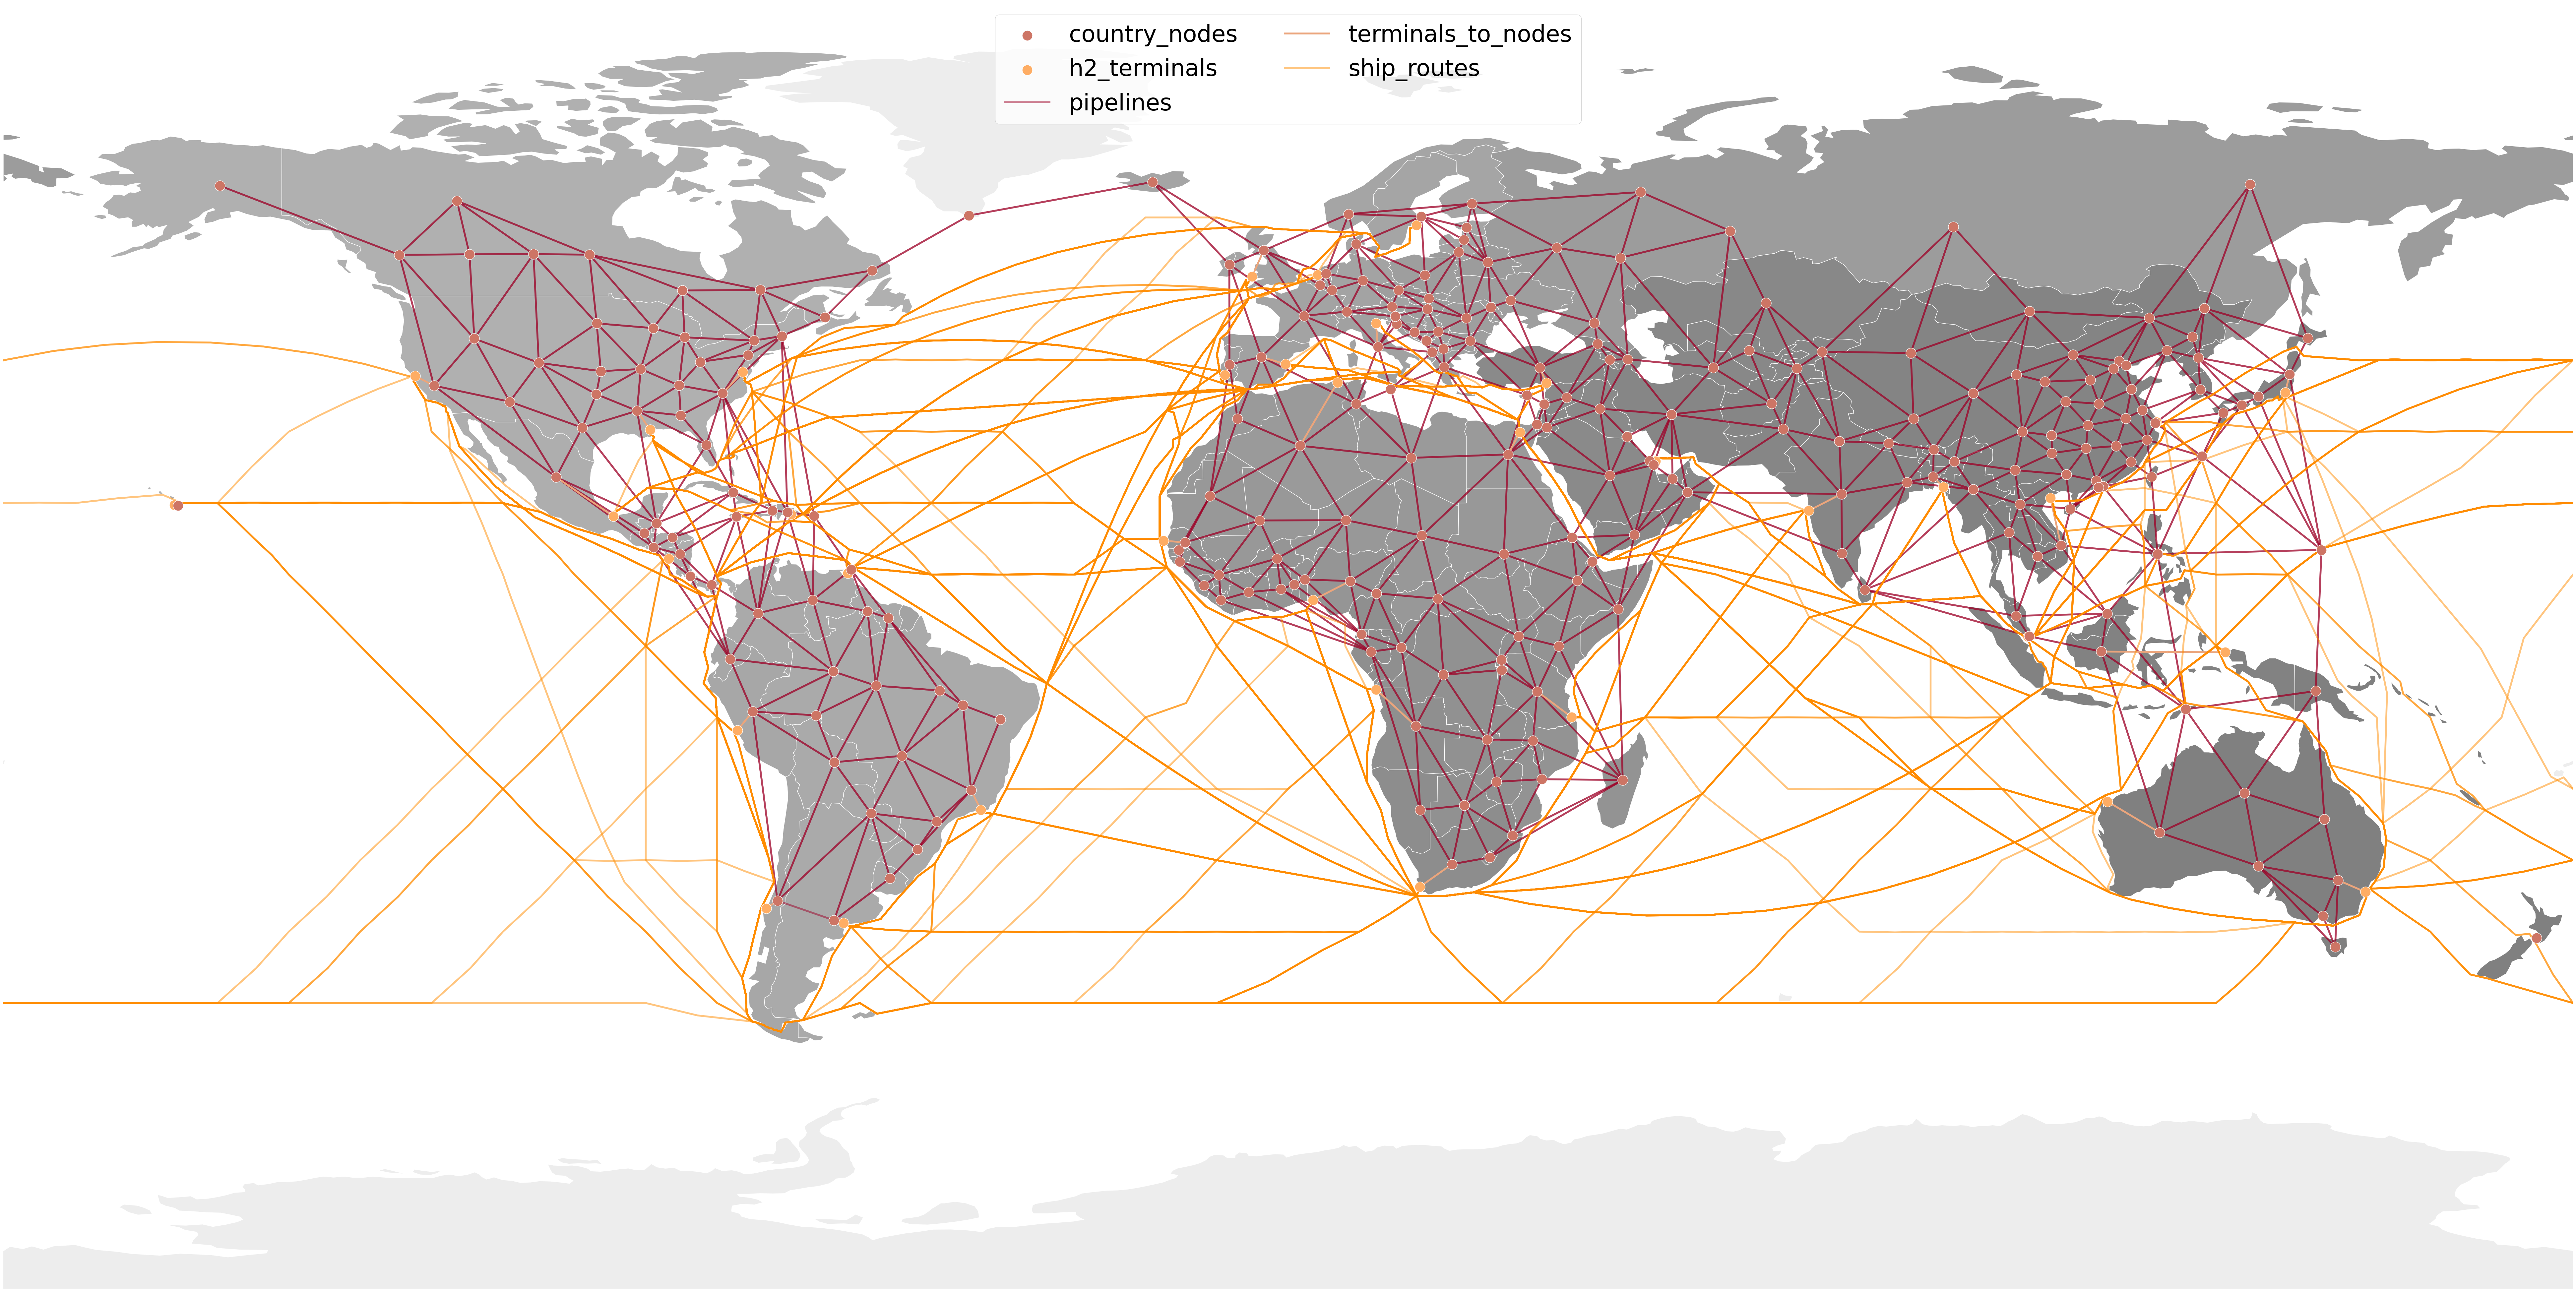

In [12]:
base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
#cities.plot(ax=base, color='black', markersize=10, alpha=0.2)
#ports.plot(ax=base, color='black', markersize=20, alpha=0.2)
#rivers.plot(ax=base, color='blue', markersize=1, alpha=0.1)
plexos_nodes.plot(ax=base, color='#cd7565', markersize=500, alpha=1, edgecolors='white', label="country_nodes", zorder=3)
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
dfline_short.plot(ax=base, color='#9e0027', linewidth=4, edgecolor='white', alpha=0.5, label="pipelines", zorder=1) #Linestringelemente
con_line.plot(ax=base, color='#eba57c', linewidth=4, edgecolor='white', alpha=1, label="terminals_to_nodes", zorder=1) #Linestringelemente
df_sr.plot(ax=base, color='#ff8c00', linewidth=4, edgecolor='white', alpha=0.5, label="ship_routes", zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
base.set_axis_off()
plt.legend(loc="upper center", ncol=2, fontsize=50)
plt.ylim(-90,90)
plt.xlim(-180,180)

Now the exports for Spine will be prepared:

What do I need?
- Nodes (node, node_el, node_h2, balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- h2_terminals (node, node_h2,  balance_type = balance_type_node, demand_el, demand_h2, y (latitude*(-1)), x (longitude))
- connection (node1, node2, name, fix_ratio_out_in_connection_flow, length)
- connection__from_node (node1, node2)
- connection__to_node (node1, node2, connection_capacity)
- cuppling units ()
- unit__node__node ()
- unit__to_node ()
- unit__from_node ()

In [13]:
terminals = h2_terminals
terminals = terminals.rename(columns={"longitude":"x", "latitude":"y"})
terminals["y"] = terminals["y"]*(-1)
terminals["length"] = con_line["length"]
terminals["balance_type"] = "balance_type_node"

terminals.head()

name           city    node           region          y   
0  h2_terminal_EU-NLD      Rotterdam  EU-NLD   central_europe -51.948455  \
1  h2_terminal_EU-PRT          Sines  EU-PRT  southern_europe -37.961098   
2  h2_terminal_EU-ESP       Valencia  EU-ESP  southern_europe -39.463713   
3  h2_terminal_EU-ITA  Porto_Levante  EU-ITA  southern_europe -45.205817   
4  h2_terminal_AS-TUR        Dortyol  AS-TUR      middle_east -36.825941   

           x                   geometry    length       balance_type  
0   4.140296   POINT (4.14030 51.94846)  1.165613  balance_type_node  
1  -8.878688  POINT (-8.87869 37.96110)  1.580536  balance_type_node  
2  -0.358820  POINT (-0.35882 39.46371)  3.534787  balance_type_node  
3  12.293656  POINT (12.29366 45.20582)  3.345095  balance_type_node  
4  36.177898  POINT (36.17790 36.82594)  2.333161  balance_type_node

In [14]:
h2_pipelines = dfline_short
#h2_pipelines.to_excel(os.path.join(data_pth_export, "transport_objects.xlsx"), sheet_name='h2_pipelines')

h2_pipelines.head()

geometry_line   
3   LINESTRING (144.75755 13.45013, 143.95555 -6.3...  \
6   LINESTRING (143.95555 -6.31499, 145.17972 -24....   
9   LINESTRING (25.74815 61.92411, 49.39031 63.56293)   
16  LINESTRING (49.39031 63.56293, 61.92033 58.10940)   
21  LINESTRING (122.09315 -26.14146, 125.72754 -8....   

                             starts                              ends   
3     POINT (144.757551 13.4501257)       POINT (143.95555 -6.314993)  \
6       POINT (143.95555 -6.314993)  POINT (145.1797201 -24.27377189)   
9        POINT (25.748151 61.92411)   POINT (49.39030527 63.56292883)   
16  POINT (49.39030527 63.56292883)   POINT (61.92032702 58.10940302)   
21  POINT (122.0931532 -26.1414604)      POINT (125.727539 -8.874217)   

        node1      h2_node1   
3   NA-USA-GU  NA-USA-GU_h2  \
6      OC-PNG     OC-PNG_h2   
9      EU-FIN     EU-FIN_h2   
16  AS-RUS-NW  AS-RUS-NW_h2   
21  OC-AUS-WA  OC-AUS-WA_h2   

                                       el_demand_ts_x   
3   {"type": "time_series", "data": {"2015-01-01T0...  \
6   {"type": "time_series", "data": {"2015-01-01T0...   
9   {"type": "time_series", "data": {"2015-01-01T0...   
16  {"type": "time_series", "data": {"2015-01-01T0...   
21  {"type": "time_series", "data": {"2015-01-01T0...   

                                       h2_demand_ts_x  node_slack_penalty_x   
3   {"type": "time_series", "data": {"2015-01-01T0...                100000  \
6   {"type": "time_series", "data": {"2015-01-01T0...                100000   
9   {"type": "time_series", "data": {"2015-01-01T0...                100000   
16  {"type": "time_series", "data": {"2015-01-01T0...                100000   
21  {"type": "time_series", "data": {"2015-01-01T0...                100000   

        node2      h2_node2   
3      OC-PNG     OC-PNG_h2  \
6   OC-AUS-QL  OC-AUS-QL_h2   
9   AS-RUS-NW  AS-RUS-NW_h2   
16  AS-RUS-UR  AS-RUS-UR_h2   
21     AS-TLS     AS-TLS_h2   

                                       el_demand_ts_y   
3   {"type": "time_series", "data": {"2015-01-01T0...  \
6   {"type": "time_series", "data": {"2015-01-01T0...   
9   {"type": "time_series", "data": {"2015-01-01T0...   
16  {"type": "time_series", "data": {"2015-01-01T0...   
21  {"type": "time_series", "data": {"2015-01-01T0...   

                                       h2_demand_ts_y  node_slack_penalty_y   
3   {"type": "time_series", "data": {"2015-01-01T0...                100000  \
6   {"type": "time_series", "data": {"2015-01-01T0...                100000   
9   {"type": "time_series", "data": {"2015-01-01T0...                100000   
16  {"type": "time_series", "data": {"2015-01-01T0...                100000   
21  {"type": "time_series", "data": {"2015-01-01T0...                100000   

                         name   
3      NA-USA-GU_h2_OC-PNG_h2  \
6      OC-PNG_h2_OC-AUS-QL_h2   
9      EU-FIN_h2_AS-RUS-NW_h2   
16  AS-RUS-NW_h2_AS-RUS-UR_h2   
21     OC-AUS-WA_h2_AS-TLS_h2   

                                             geometry  connection_flow_cost   
3   LINESTRING (144.75755 13.45013, 143.95555 -6.3...              0.000002  \
6   LINESTRING (143.95555 -6.31499, 145.17972 -24....              0.000002   
9   LINESTRING (25.74815 61.92411, 49.39031 63.56293)              0.000002   
16  LINESTRING (49.39031 63.56293, 61.92033 58.10940)              0.000002   
21  LINESTRING (122.09315 -26.14146, 125.72754 -8....              0.000002   

    connection_capacity     length  
3                100000  19.781383  
6                100000  18.000454  
9                100000  23.698886  
16               100000  13.665372  
21               100000  17.645579

In [15]:
# create a excel writer object
with pd.ExcelWriter(os.path.join(data_pth_export, "transport_objects.xlsx")) as writer:
   
    # use to_excel function and specify the sheet_name and index to store the dataframe in specified sheet
    test_df.to_excel(writer, sheet_name="nodes", index=False)
    h2_pipelines.to_excel(writer, sheet_name="h2_pipelines", index=False)
    terminals.to_excel(writer, sheet_name="h2_ships", index=False)
    con_line.to_excel(writer, sheet_name="terminal_connections", index=False)
    df_sr.to_excel(writer, sheet_name="shipping_routes", index=False)

In [25]:
df_sr_results = df_sr
h2_pipelines_results = h2_pipelines
con_line_results = con_line

h2_pipelines_results["h2_flow"] = randomize(h2_pipelines_results, 1)
#df_sr_results["h2_flow"] = randomize(df_sr_results, 10)

#results = pd.read_excel("""PATHexported_db_url@Output.xlsx""")

#results.head()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(-180.0, 180.0)

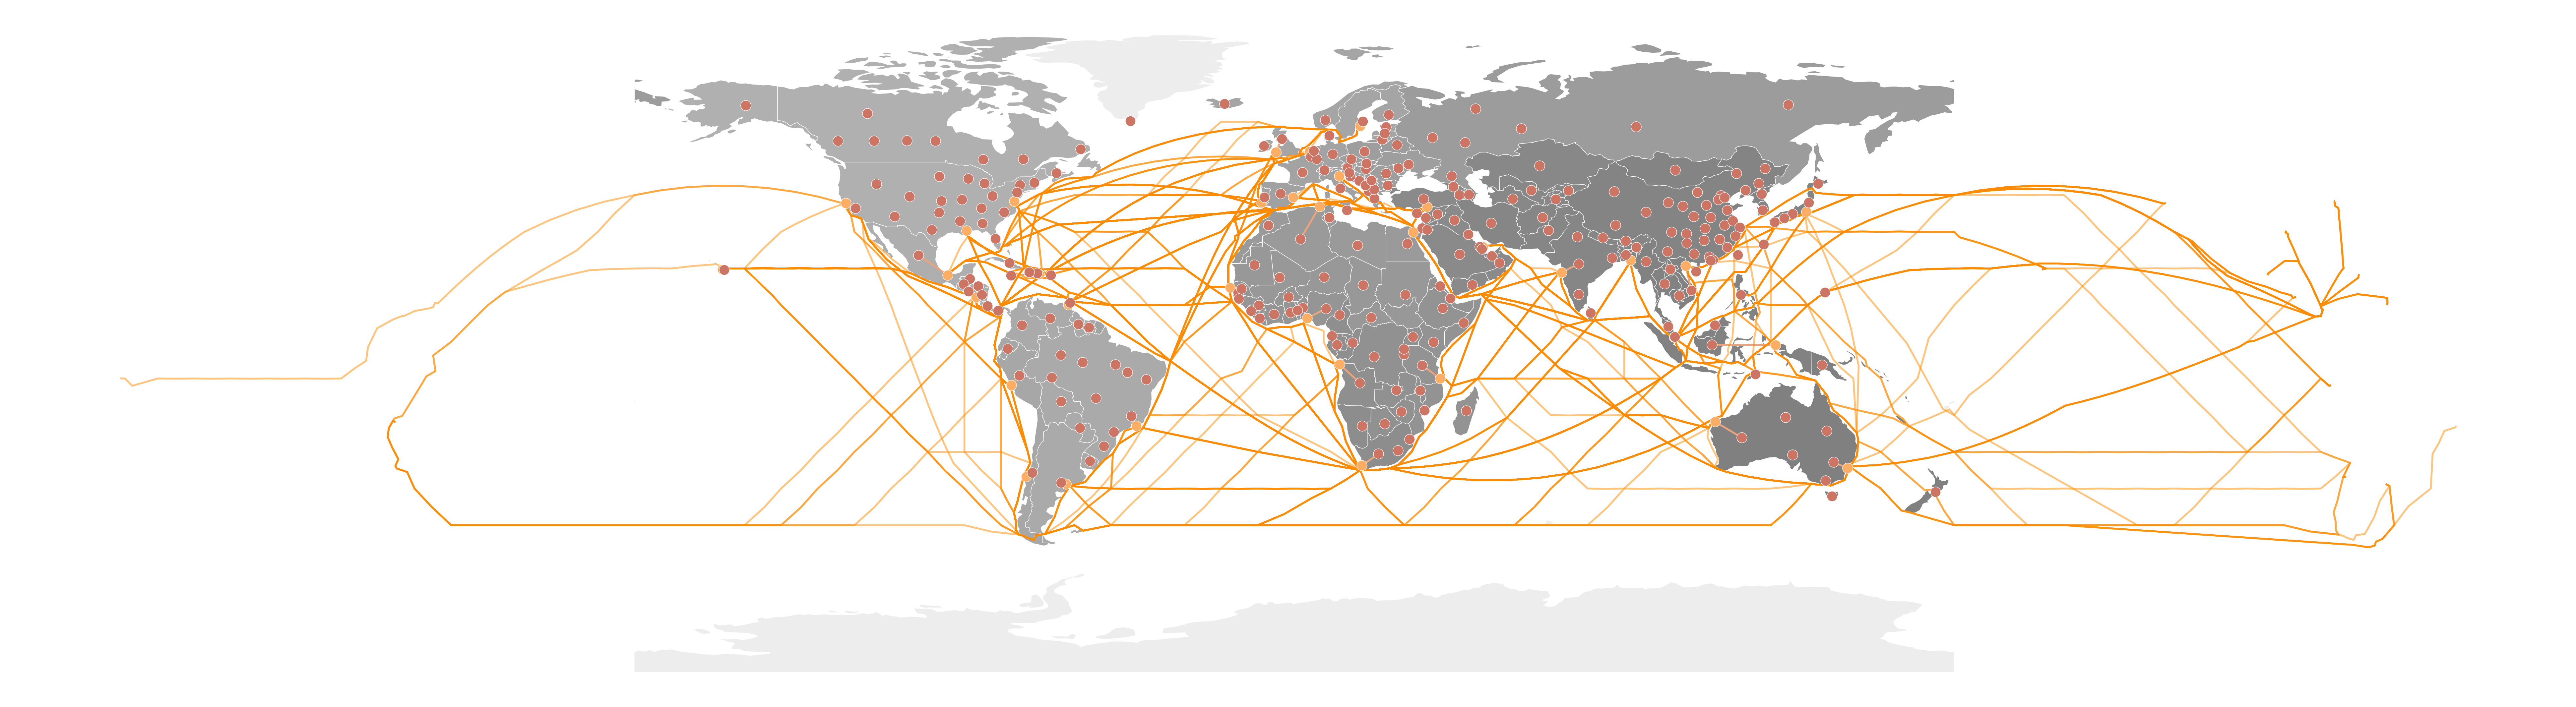

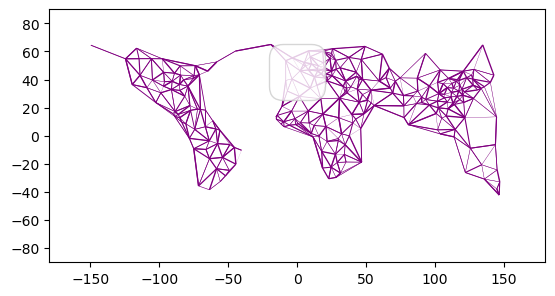

In [31]:
base = world.plot(color='#a8a8a8', linewidth=0.5, edgecolor='white', figsize=(100,80), alpha=0.2)
north_america.plot(ax=base, color="#b0b0b0", markersize=5, edgecolor='white')
central_america.plot(ax=base, color='#aeaeae', markersize=5, edgecolor='white')
caribbean.plot(ax=base, color='#acacac', markersize=5, edgecolor='white')
east_coast_south_america.plot(ax=base, color='#aaaaaa', markersize=5, edgecolor='white')
west_coast_south_america.plot(ax=base, color='#a7a7a7', markersize=5, edgecolor='white')
northern_europe.plot(ax=base, color='#a5a5a5', markersize=5, edgecolor='white')
central_europe.plot(ax=base, color='#a3a3a3', markersize=5, edgecolor='white')
southern_europe.plot(ax=base, color='#a1a1a1', markersize=5, edgecolor='white')
eastern_europe.plot(ax=base, color='#9e9e9e', markersize=5, edgecolor='white')
russia_belarus.plot(ax=base, color='#9c9c9c', markersize=5, edgecolor='white')
northern_africa.plot(ax=base, color='#9a9a9a', markersize=5, edgecolor='white')
sahel_zone.plot(ax=base, color='#989898', markersize=5, edgecolor='white')
north_west_coast_africa.plot(ax=base, color='#959595', markersize=5, edgecolor='white')
east_coast_africa.plot(ax=base, color='#939393', markersize=5, edgecolor='white')
south_central_africa.plot(ax=base, color='#919191', markersize=5, edgecolor='white')
west_coast_africa.plot(ax=base, color='#8f8f8f', markersize=5, edgecolor='white')
southern_africa.plot(ax=base, color='#8d8d8d', markersize=5, edgecolor='white')
middle_east.plot(ax=base, color='#8a8a8a', markersize=5, edgecolor='white')
central_asia.plot(ax=base, color='#888888', markersize=5, edgecolor='white')
southern_asia.plot(ax=base, color='#868686', markersize=5, edgecolor='white')
eastern_asia.plot(ax=base, color='#848484', markersize=5, edgecolor='white')
south_eastern_asia.plot(ax=base, color='#828282', markersize=5, edgecolor='white')
australia_oceania.plot(ax=base, color='#808080', markersize=5, edgecolor='white')
plexos_nodes.plot(ax=base, color='#cd7565', markersize=500, alpha=1, edgecolors='white', label="country_nodes", zorder=3)
h2_terminals.plot(ax=base, color='#fead64', markersize=500, alpha=1,edgecolors='white', label="h2_terminals", zorder=2)
h2_pipelines_results.plot(column='name', cmap='BuGn', linewidth=h2_pipelines_results['h2_flow'], edgecolor='purple', vmin=0, vmax=1)
#h2_pipelines_results.plot(ax=base, color='#9e0027', linewidth=4, edgecolor='white', alpha=0.5, label="pipelines", zorder=1) #Linestringelemente
con_line_results.plot(ax=base, color='#eba57c', linewidth=4, edgecolor='white', alpha=1, label="terminals_to_nodes", zorder=1) #Linestringelemente
df_sr_results.plot(ax=base, color='#ff8c00', linewidth=4, edgecolor='white', alpha=0.5, label="ship_routes", zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
#df_sr.plot(ax=base, color='black', linewidth=3, edgecolor='white', alpha=0.5, zorder=1) #Linestringelemente
base.set_axis_off()
plt.legend(loc="upper center", ncol=2, fontsize=50)
plt.ylim(-90,90)
plt.xlim(-180,180)